In [1]:
# pip install gensim -q

# 🎬 Movie Recommendation System (Content-Based Filtering)

### ✅ Objective
Build a movie recommendation system that suggests **similar movies** based on **content features** like genres (and optionally title text).

### ✅ Why this project?
Recommendation systems power platforms like **Netflix / Prime Video / YouTube / Spotify**.  
This project demonstrates **feature engineering + similarity search + recommendation logic**.

### ✅ Dataset
- Source: MovieLens (movies metadata)
- Rows: ~9.7K movies
- Columns: movieId, title, genres

### ✅ Output
Given a movie title, recommend **Top-N similar movies** using cosine similarity.


In [35]:
import numpy as np
import pandas as pd
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")


from gensim.models import Word2Vec


In [47]:
# Lets Load The dataset
data = pd.read_csv(r'movies (1).csv')

In [4]:
data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## 2. Data Quality Checks
We check:
- dataset shape  
- missing values  
- duplicate titles  
- movies with missing genres  


In [5]:
# Lets see the shape of the data
data.shape

(9742, 3)

In [6]:
# Lets check for the missing values

data.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [7]:
# There are no missing values in the data

In [37]:
dup_titles = data.duplicated(subset=["title"]).sum()
print("\nDuplicate titles:", dup_titles)

no_genres = (data["genres"] == "(no genres listed)").sum()
print("\n(No genres listed):", no_genres)


Duplicate titles: 5

(No genres listed): 0


## 3. Feature Engineering
To build a strong recommender, we create:
- `year` extracted from title  
- `clean_title` without year  
- cleaned genres text for similarity modeling  


In [8]:
# Lets convert text to tokens
data['genres_token'] = data['genres'].str.lower().str.split(pat='|')

In [9]:
data

,movieId,title,genres,genres_token
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[adventure, animation, children, comedy, fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[adventure, children, fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[comedy, romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[comedy, drama, romance]"
4,5,Father of the Bride Part II (1995),Comedy,[comedy]
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,"[action, animation, comedy, fantasy]"
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"[animation, comedy, fantasy]"
9739,193585,Flint (2017),Drama,[drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"[action, animation]"


In [10]:
# We need to remove the movies where there is no genre listed, it is a missing values

data[data['genres']=='(no genres listed)'].index

Index([8517, 8684, 8687, 8782, 8836, 8902, 9033, 9053, 9070, 9091, 9138, 9178,
       9217, 9248, 9259, 9307, 9316, 9348, 9413, 9426, 9448, 9478, 9514, 9515,
       9518, 9525, 9534, 9541, 9562, 9573, 9611, 9661, 9663, 9669],
      dtype='int64')

In [11]:
drop_index = data[data['genres']=='(no genres listed)'].index
data.drop(index=drop_index,inplace=True)
data.reset_index(inplace=True)

In [41]:
import re

def extract_year(title):
    match = re.search(r"\((\d{4})\)", title)
    return int(match.group(1)) if match else np.nan
data["year"] = data["title"].apply(extract_year)

## 4. Exploratory Data Analysis (EDA)
We explore:
- movies released per year  
- most frequent genres  
- how many genres a movie typically has  


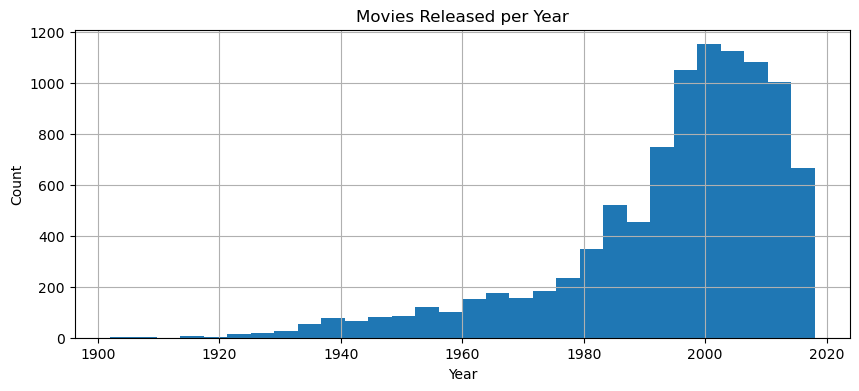

In [42]:
plt.figure(figsize=(10,4))
data["year"].dropna().astype(int).hist(bins=30)
plt.title("Movies Released per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


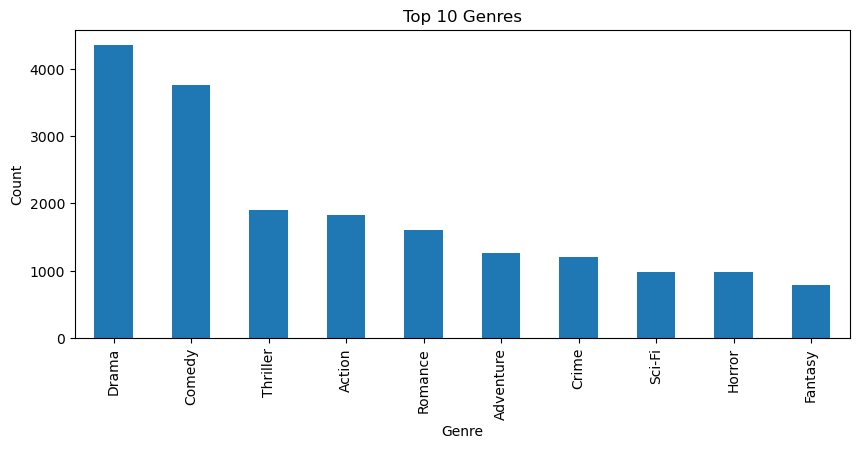

In [43]:
genre_counts = (
    data["genres"]
    .str.split("|")
    .explode()
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,4))
genre_counts.plot(kind="bar")
plt.title("Top 10 Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()


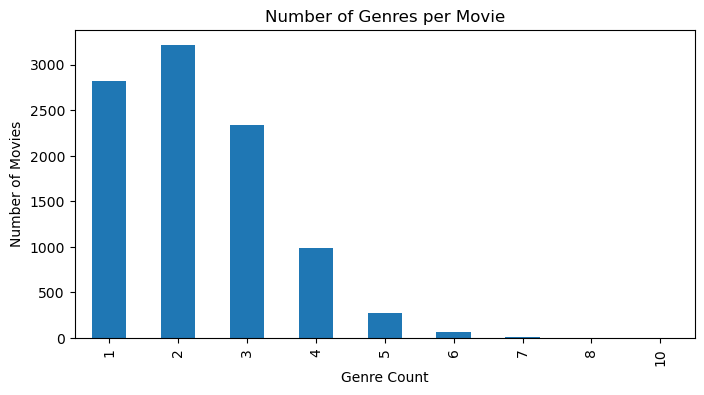

In [45]:
data["genre_count"] = data["genres"].apply(lambda x: len(x.split("|")))

plt.figure(figsize=(8,4))
data["genre_count"].value_counts().sort_index().plot(kind="bar")
plt.title("Number of Genres per Movie")
plt.xlabel("Genre Count")
plt.ylabel("Number of Movies")
plt.show()


The dataset contains multi-genre movies, which makes genre-based similarity useful.

Drama/Comedy are the most frequent genres, meaning recommendations can become biased toward popular genres

In [12]:
# Lets Train SkiGram model on our data and generate word vectors from the tokens

embed_model = Word2Vec(sentences=data['genres_token'],window=2,vector_size=30,sg=1)

SkipGram works well when we want to learn representations of genres even with smaller context windows.

Word2Vec learns relationships between genres (example: Adventure and Action often appear together).

In [13]:
embed_model.wv['children']

array([-0.16588748, -0.04419278,  0.4492076 , -0.2156326 ,  0.150978  ,
       -0.02839581,  0.26054698,  0.28426236, -0.28229004, -0.10642502,
        0.16762255,  0.05206306, -0.09578957, -0.26913196,  0.24219486,
       -0.20362593,  0.52466094,  0.10708221, -0.3067169 ,  0.13782454,
        0.06504226, -0.1347758 ,  0.11097581,  0.3063734 , -0.00551083,
        0.23291437,  0.4659106 ,  0.3429363 , -0.1632566 , -0.14152002],
      dtype=float32)

Averaging embeddings creates a fixed-length vector per movie.

It enables cosine similarity to measure closeness between movies in the embedding space

In [14]:
embed_model.wv.most_similar('romance',topn=5)

[('animation', 0.9897767901420593),
 ('thriller', 0.9894630312919617),
 ('sci-fi', 0.9893214702606201),
 ('adventure', 0.9891542196273804),
 ('crime', 0.9881117343902588)]

In [15]:
vocabulary = embed_model.wv.index_to_key

### Lets try some pretrained model (GLOVE)

In [16]:
import gensim.downloader as gen_download

In [17]:
model_glove = gen_download.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [18]:
model_glove['horror']

array([ 0.67846 , -0.26964 ,  0.61851 ,  0.046141,  0.61987 ,  0.051023,
        1.8133  ,  0.8274  ,  0.30019 , -0.5699  , -0.15057 , -0.38452 ,
       -2.1337  , -0.017248,  0.89657 ,  1.1567  ,  0.14458 ,  0.61671 ,
       -0.13564 ,  0.067028, -0.63978 ,  0.69494 , -0.69101 , -0.037431,
        0.98344 ], dtype=float32)

In [19]:
model_glove['documentary']

array([ 0.30368 ,  0.081423,  0.79418 , -0.3667  ,  0.61585 , -0.89648 ,
        1.6116  , -0.74739 ,  0.21872 , -1.4537  ,  0.52975 ,  1.3648  ,
       -2.4574  ,  0.18059 ,  0.35748 ,  0.44751 ,  0.011323,  0.77678 ,
       -0.10042 ,  0.33302 , -0.40845 , -0.24913 , -0.86413 , -1.3932  ,
        0.70769 ], dtype=float32)

In [20]:
vocabulary

['drama',
 'comedy',
 'thriller',
 'action',
 'romance',
 'adventure',
 'crime',
 'sci-fi',
 'horror',
 'fantasy',
 'children',
 'animation',
 'mystery',
 'documentary',
 'war',
 'musical',
 'western',
 'imax',
 'film-noir']

In [21]:
# Lets convert these tokens to word embeddings
data['genres_embeddings'] = data['genres_token'].apply(lambda x:[embed_model.wv[w] for w in x])

In [22]:
data.head()

,index,movieId,title,genres,genres_token,genres_embeddings
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[adventure, animation, children, comedy, fantasy]","[[-0.123093024, -0.13559371, 0.5182981, -0.235..."
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,"[adventure, children, fantasy]","[[-0.123093024, -0.13559371, 0.5182981, -0.235..."
2,2,3,Grumpier Old Men (1995),Comedy|Romance,"[comedy, romance]","[[-0.15113193, -0.086243644, 0.468775, -0.2293..."
3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[comedy, drama, romance]","[[-0.15113193, -0.086243644, 0.468775, -0.2293..."
4,4,5,Father of the Bride Part II (1995),Comedy,[comedy],"[[-0.15113193, -0.086243644, 0.468775, -0.2293..."


In [23]:
data['genres_embeddings'][0]

[array([-0.12309302, -0.13559371,  0.5182981 , -0.23586218,  0.14684187,
         0.01824878,  0.32806876,  0.32843667, -0.36432678, -0.05981874,
         0.12800215,  0.05162159, -0.146181  , -0.30671746,  0.24772888,
        -0.20175964,  0.6062132 ,  0.12175484, -0.2962021 ,  0.15149383,
         0.05609703, -0.1759955 ,  0.11155435,  0.33477232,  0.03515649,
         0.23499638,  0.48964512,  0.37131038, -0.18613592, -0.18187608],
       dtype=float32),
 array([-0.1358278 , -0.10733554,  0.44987345, -0.23133495,  0.14846098,
         0.02259178,  0.309348  ,  0.25720948, -0.36520064, -0.04377344,
         0.15305851,  0.05247273, -0.09914961, -0.27467895,  0.24248976,
        -0.19354779,  0.536775  ,  0.1200828 , -0.29994193,  0.11069573,
         0.07638394, -0.13227703,  0.05066722,  0.24608833,  0.01335237,
         0.2352122 ,  0.4757992 ,  0.38021   , -0.16341737, -0.17056054],
       dtype=float32),
 array([-0.16588748, -0.04419278,  0.4492076 , -0.2156326 ,  0.150978  ,
   

In [24]:
data['genres_avg_embeddings'] = data['genres_embeddings'].apply(lambda x : np.mean(x,axis=0))

In [25]:
data.head()

,index,movieId,title,genres,genres_token,genres_embeddings,genres_avg_embeddings
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[adventure, animation, children, comedy, fantasy]","[[-0.123093024, -0.13559371, 0.5182981, -0.235...","[-0.14073034, -0.08843829, 0.4727652, -0.22474..."
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,"[adventure, children, fantasy]","[[-0.123093024, -0.13559371, 0.5182981, -0.235...","[-0.1388973, -0.082870774, 0.48172584, -0.2210..."
2,2,3,Grumpier Old Men (1995),Comedy|Romance,"[comedy, romance]","[[-0.15113193, -0.086243644, 0.468775, -0.2293...","[-0.11834741, -0.08063662, 0.4103042, -0.20827..."
3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[comedy, drama, romance]","[[-0.15113193, -0.086243644, 0.468775, -0.2293...","[-0.12229103, -0.08060539, 0.42592606, -0.1957..."
4,4,5,Father of the Bride Part II (1995),Comedy,[comedy],"[[-0.15113193, -0.086243644, 0.468775, -0.2293...","[-0.15113193, -0.086243644, 0.468775, -0.22938..."


In [26]:
data['genres_avg_embeddings'][0]

array([-0.14073034, -0.08843829,  0.4727652 , -0.2247478 ,  0.1369218 ,
        0.00274923,  0.29437414,  0.2755081 , -0.32815152, -0.07613514,
        0.13734753,  0.04229671, -0.12522212, -0.27227342,  0.2286736 ,
       -0.2008404 ,  0.5214715 ,  0.12198558, -0.28223044,  0.12986109,
        0.05319721, -0.12974977,  0.08878448,  0.28145748,  0.03462562,
        0.22987056,  0.4702916 ,  0.34498635, -0.17083676, -0.15412171],
      dtype=float32)

## RECOMMENDATION SYSTEM

In [27]:
# Create a similarity matrix

simi_matrix = cosine_similarity(data['genres_avg_embeddings'].tolist())

In [28]:
simi_matrix

array([[0.99999994, 0.99954426, 0.99664706, ..., 0.9919816 , 0.997268  ,
        0.99469155],
       [0.99954426, 0.9999999 , 0.9948732 , ..., 0.9918029 , 0.99598515,
        0.99233145],
       [0.99664706, 0.9948732 , 1.0000001 , ..., 0.98690903, 0.9936466 ,
        0.99739486],
       ...,
       [0.9919816 , 0.9918029 , 0.98690903, ..., 0.99999994, 0.99075454,
        0.9868733 ],
       [0.997268  , 0.99598515, 0.9936466 , ..., 0.99075454, 1.0000002 ,
        0.99050957],
       [0.99469155, 0.99233145, 0.99739486, ..., 0.9868733 , 0.99050957,
        1.        ]], dtype=float32)

In [46]:
# Lets define a function to get the movie name from user and return most similar movie

def recommender(selected_movie,nos=5):
  if selected_movie in data['title'].values:
    idx = data[data['title']== selected_movie].index[0]
    top_n_idx = simi_matrix[idx].argsort()[::-1][1:nos+1]
    for i in top_n_idx:
      return data.loc[top_n_idx, ["title", "genres"]].reset_index(drop=True)
    else:
        return "❌ Movie Not Found"

In [30]:
movie_name = 'Father of the Bride Part II (1995)'
data[data['title']== movie_name].index[0]

np.int64(4)

In [31]:
simi_matrix[9703].argsort()[::-1][1:6]
# argsort sort the indexes on the bases of the similarity

array([8545, 9270, 8128, 9431, 6462])

In [32]:
recommender('Toy Story (1995)')

Asterix and the Vikings (Astérix et les Vikings) (2006)
Tale of Despereaux, The (2008)
Turbo (2013)
Moana (2016)
Monsters, Inc. (2001)


In [33]:
recommender('Jumanji (1995)')

The Cave of the Golden Rose (1991)
NeverEnding Story III, The (1994)
Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)
Water Horse: Legend of the Deep, The (2007)
Escape to Witch Mountain (1975)


# Conclusion

Built content-based movie recommender using Word2Vec genre embeddings + cosine similarity

System recommends Top-N similar movies based on genre proximity

Ready for extension into hybrid recommender using ratings data

## Limitations + Future Work

Limitations

Genre-only recommendations ignore plot/actors

Duplicate titles can confuse lookup

No personalization (no user-item interaction)

Future Work

Add TF-IDF baseline for comparison

Hybrid model using ratings dataset

Add fuzzy matching for misspelled titles